# Build Market Movement Classifier. 

In [1]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf
import spacy 
import xgboost as xgb
import shap 
import optuna 
from optuna import visualization as opt_viz 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import ElasticNet 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error 
from feature_engine.encoding import OneHotEncoder 

# Change the current directory from (./notebook) to root directory. 
if not re.match(r".+/MADS-M2-estimating-news-impact-on-financial-market$", os.getcwd()): 
	os.chdir("../..") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules.manage_files import ManageFiles 
from source.modules import visualizer 
from source.modules.processor_topic import raw_token_input 
from source.modules.processor_estim import (
	ColumnSelector, ExtractSentiment, ExtractTopic, ToSparse
) 

# Custom configs. 
from source.config_py.config import (
	DIR_MLSPACY, DIR_MLTOPIC, DIR_MLESTIM, 
	TICKER_TO_COLLECT, TICKER_DATE_COLLECT, 
	PARAM_SEED, 
)

# Preview. 
print(os.getcwd()) 

/Users/lioneltay/.local/share/virtualenvs/MADS-M2-estimating-news-impact-on-financia-G1YPmgZm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_694_695_milestone_2_Eric_Gilbert/submission/MADS-M2-estimating-news-impact-on-financial-market


## Configurations (general). 

In [2]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# For clearing the output. Not important. 
clear_output()

## Load ticker data. 

In [3]:
df_tickers = pd.DataFrame() 

# Get the ticker class object. 
tickers = [(t, yf.Ticker(t)) for t in TICKER_TO_COLLECT] 

for tname, tobject in tickers: 
	tname = tname.lower() 

	# Get the ticker history data. 
	df_ticker = tobject.history(period="max", interval="1d", start=TICKER_DATE_COLLECT[0], end=TICKER_DATE_COLLECT[1], auto_adjust=True, rounding=True) 

	# Rename the columns. 
	df_ticker.columns = [f"{tname}_{c}".lower().replace(" ", "_") for c in df_ticker.columns] 

	# Keep specific columns only. 
	usecols = [f"{tname}_open", f"{tname}_close", f"{tname}_volume"]  

	# Concat the columns. 
	df_tickers = pd.concat([df_tickers, df_ticker[usecols]], axis="columns") 

# Preview. 
df_tickers

,spy_open,spy_close,spy_volume
Date,,,
1998-11-30,77.91,76.02,8705400
1998-12-01,76.02,77.00,8950600
1998-12-02,76.74,76.78,7495500
1998-12-03,76.76,75.51,12145300
1998-12-04,76.35,77.49,10339500
...,...,...,...
2022-03-14,419.59,415.71,95729200
2022-03-15,418.47,424.85,106219100
2022-03-16,428.56,434.27,144954800


## Preprocess ticker data. 

### Create labels (rolling t-score). 

In [4]:
# Define the rolling window and min period. 
window_avg, window_std = 365, 365 
period_avg, period_std = 365, 365 

# Define market movement scale. 
mv_lo, mv_hi = 0.25, 0.75 

# Create labels for each ticker symbol. 
for tname in TICKER_TO_COLLECT: 
	tname = tname.lower() 

	# Compute the Log return of the ticker price. 
	df_tickers[f"{tname}_logret_c2c"] = np.log(df_tickers[f"{tname}_close"]) - np.log(df_tickers[f"{tname}_close"].shift(1)) 
	df_tickers[f"{tname}_logret_o2c"] = np.log(df_tickers[f"{tname}_close"]) - np.log(df_tickers[f"{tname}_open"]) 
	df_tickers[f"{tname}_logret_c2o"] = np.log(df_tickers[f"{tname}_open"].shift(-1)) - np.log(df_tickers[f"{tname}_close"]) 

	# Compute the tscore for price change. 
	logret_c2c_ravg = df_tickers[f"{tname}_logret_c2c"].rolling(window=window_avg, min_periods=period_avg, win_type=None).mean() 
	logret_o2c_ravg = df_tickers[f"{tname}_logret_o2c"].rolling(window=window_avg, min_periods=period_avg, win_type=None).mean() 
	logret_c2o_ravg = df_tickers[f"{tname}_logret_c2o"].rolling(window=window_avg, min_periods=period_avg, win_type=None).mean() 

	logret_c2c_rstd = df_tickers[f"{tname}_logret_c2c"].rolling(window=window_std, min_periods=period_std, win_type=None).std(ddof=1) 
	logret_o2c_rstd = df_tickers[f"{tname}_logret_o2c"].rolling(window=window_std, min_periods=period_std, win_type=None).std(ddof=1) 
	logret_c2o_rstd = df_tickers[f"{tname}_logret_c2o"].rolling(window=window_std, min_periods=period_std, win_type=None).std(ddof=1) 

	df_tickers[f"{tname}_tscore_c2c"] = (df_tickers[f"{tname}_logret_c2c"] - logret_c2c_ravg) / logret_c2c_rstd 
	df_tickers[f"{tname}_tscore_o2c"] = (df_tickers[f"{tname}_logret_o2c"] - logret_o2c_ravg) / logret_o2c_rstd 
	df_tickers[f"{tname}_tscore_c2o"] = (df_tickers[f"{tname}_logret_c2o"] - logret_c2o_ravg) / logret_c2o_rstd 

	# Define the market movement scale. 
	df_tickers[f"{tname}_mktmv_c2c"] = 1
	df_tickers[f"{tname}_mktmv_o2c"] = 1
	df_tickers[f"{tname}_mktmv_c2o"] = 1

	df_tickers.loc[df_tickers[f"{tname}_tscore_c2c"] >= 0.75, f"{tname}_mktmv_c2c"] = 2
	df_tickers.loc[df_tickers[f"{tname}_tscore_o2c"] >= 0.75, f"{tname}_mktmv_o2c"] = 2
	df_tickers.loc[df_tickers[f"{tname}_tscore_c2o"] >= 0.75, f"{tname}_mktmv_c2o"] = 2

	df_tickers.loc[df_tickers[f"{tname}_tscore_c2c"] <= 0.25, f"{tname}_mktmv_c2c"] = 0
	df_tickers.loc[df_tickers[f"{tname}_tscore_o2c"] <= 0.25, f"{tname}_mktmv_o2c"] = 0
	df_tickers.loc[df_tickers[f"{tname}_tscore_c2o"] <= 0.25, f"{tname}_mktmv_c2o"] = 0

# Lowercase the name. 
df_tickers.index.name = df_tickers.index.name.lower() 

# Preview. 
df_tickers

,spy_open,spy_close,spy_volume,spy_logret_c2c,spy_logret_o2c,spy_logret_c2o,spy_tscore_c2c,spy_tscore_o2c,spy_tscore_c2o,spy_mktmv_c2c,spy_mktmv_o2c,spy_mktmv_c2o
date,,,,,,,,,,,,
1998-11-30,77.91,76.02,8705400,NaN,-0.024558,0.000000,NaN,NaN,NaN,1,1,1
1998-12-01,76.02,77.00,8950600,0.012809,0.012809,-0.003382,NaN,NaN,NaN,1,1,1
1998-12-02,76.74,76.78,7495500,-0.002861,0.000521,-0.000261,NaN,NaN,NaN,1,1,1
1998-12-03,76.76,75.51,12145300,-0.016679,-0.016419,0.011063,NaN,NaN,NaN,1,1,1
1998-12-04,76.35,77.49,10339500,0.025884,0.014821,-0.002584,NaN,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-14,419.59,415.71,95729200,-0.007334,-0.009290,0.006617,-0.843413,-1.167940,0.985262,0,0,2
2022-03-15,418.47,424.85,106219100,0.021748,0.015131,0.008695,2.210934,1.899331,1.329676,2,2,2
2022-03-16,428.56,434.27,144954800,0.021930,0.013236,-0.004662,2.209529,1.654139,-0.900536,2,2,0


### Visualize the label distribution. 

In [5]:
print(df_tickers["spy_mktmv_c2c"].value_counts(normalize=True)) 

visualizer.plot_discre_dist(df_tickers, x="spy_mktmv_c2c") 

0    0.590211
1    0.248124
2    0.161664
Name: spy_mktmv_c2c, dtype: float64


alt.Chart(...)

Text(0.5, 1.0, 'spy_tscore_c2c')

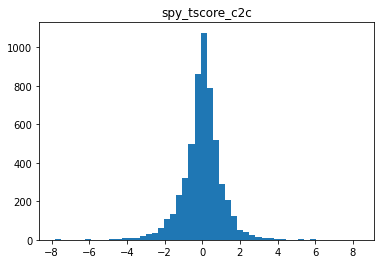

In [6]:
colname = "spy_tscore_c2c" 

plt.hist(x=df_tickers[colname], bins=50) 
plt.title(colname) 

### Create feature(s) related to ticker data. 

## Load news dataset with entities. 

In [7]:
# Load dataset. 
df_business = manage_files.read_from_parquet(filename="cnn_news_business.parquet") 

# FIlter columns
usecols = ["date", "category", "section", "headline", "second_headline", "description", "article_text", "entities"] 
df_business = df_business[usecols] 

# Get entities text. 
df_business["theme_sub"] = df_business["entities"].str["title"] 

# Preview. 
df_business 

Read from (cnn_news_business.parquet)


,date,category,section,headline,second_headline,description,article_text,entities,theme_sub
headline_id,,,,,,,,,
3,2022-03-18,business,success,"Two years later, remote work has changed milli...","Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,The pandemic thrust the working world into a n...,"{'characters': [[[ 0 11], [ 4 11], [922 933], ...","[COVID-19 pandemic, Employment, World, Learnin..."
4,2022-03-19,business,investing,Why March is so volatile for stocks - CNN,Why March is so volatile for stocks,March Madness isn't just for college basketbal...,New York (CNN Business)March Madness isn't jus...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, C..."
5,2022-03-20,business,investing,Stocks week ahead: Big Oil rakes in billions a...,Big Oil rakes in billions as prices soar. Lawm...,"As crude prices surge, oil companies are rakin...",A version of this story first appeared in CNN ...,"{'characters': [[[42 44], [140 142], [6077 607...","[CNN, CNN Business, Business, Human rights, Ne..."
6,2022-03-18,business,energy,Oil 'emergency': Work from home and drive slow...,Oil 'emergency': Work from home and drive slow...,Governments around the world must consider dra...,New York (CNN Business)Governments around the ...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, G..."
7,2022-03-20,business,perspectives,Opinion: Technology is transforming the nature...,Technology is transforming the nature of money...,The convenience of digital payments to both co...,This interview has been edited from its origin...,"{'characters': [[[105 137], [109 137], [728 75...","[International Monetary Fund, Money, Finance, ..."
...,...,...,...,...,...,...,...,...,...
10407,2022-01-13,business,business,Nation's top trade groups hail SCOTUS ruling a...,Nation's top trade groups hail SCOTUS ruling a...,The nation's largest industry trade groups are...,(CNN Business)The nation's largest industry t...,"{'characters': [[[2 4]], [[ 2 13]], [[ 6 13], ...","[CNN, CNN Business, Business, Industrial Revol..."
10408,2022-01-04,business,business,Port of Los Angeles traffic sets record - CNN,Port of Los Angeles traffic sets record in 2021,A record-setting 10.7 million 20-foot containe...,(CNN)A record-setting 10.7 million 20-foot co...,"{'characters': [[[2 4]], [[74 77], [233 236], ...","[CNN, Port, Port of Los Angeles, Los Angeles, ..."
10409,2021-12-06,business,business,"Ford delays return to office for 30,000 worker...","Ford delays return to office for 30,000 worker...",Ford Motor Co. is pushing its return-to-office...,New York (CNN Business)Ford Motor Co. is pushi...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York (state), CNN, CNN Business, Business..."


### Merge with ticker data. 

In [8]:
# Make a copy to avoid overwriting the original. 
df_marketnews = df_business.copy() 

# Merge the columns. 
usecols = ["spy_mktmv_c2c", "spy_tscore_c2c"] 
df_marketnews = df_marketnews.merge(right=df_tickers[usecols], how="left", left_on="date", right_index=True) 

# Preview. 
df_marketnews

,date,category,section,headline,second_headline,description,article_text,entities,theme_sub,spy_mktmv_c2c,spy_tscore_c2c
headline_id,,,,,,,,,,,
3,2022-03-18,business,success,"Two years later, remote work has changed milli...","Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,The pandemic thrust the working world into a n...,"{'characters': [[[ 0 11], [ 4 11], [922 933], ...","[COVID-19 pandemic, Employment, World, Learnin...",2.0,1.056214
4,2022-03-19,business,investing,Why March is so volatile for stocks - CNN,Why March is so volatile for stocks,March Madness isn't just for college basketbal...,New York (CNN Business)March Madness isn't jus...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, C...",NaN,NaN
5,2022-03-20,business,investing,Stocks week ahead: Big Oil rakes in billions a...,Big Oil rakes in billions as prices soar. Lawm...,"As crude prices surge, oil companies are rakin...",A version of this story first appeared in CNN ...,"{'characters': [[[42 44], [140 142], [6077 607...","[CNN, CNN Business, Business, Human rights, Ne...",NaN,NaN
6,2022-03-18,business,energy,Oil 'emergency': Work from home and drive slow...,Oil 'emergency': Work from home and drive slow...,Governments around the world must consider dra...,New York (CNN Business)Governments around the ...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York City, CNN, CNN Business, Business, G...",2.0,1.056214
7,2022-03-20,business,perspectives,Opinion: Technology is transforming the nature...,Technology is transforming the nature of money...,The convenience of digital payments to both co...,This interview has been edited from its origin...,"{'characters': [[[105 137], [109 137], [728 75...","[International Monetary Fund, Money, Finance, ...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10407,2022-01-13,business,business,Nation's top trade groups hail SCOTUS ruling a...,Nation's top trade groups hail SCOTUS ruling a...,The nation's largest industry trade groups are...,(CNN Business)The nation's largest industry t...,"{'characters': [[[2 4]], [[ 2 13]], [[ 6 13], ...","[CNN, CNN Business, Business, Industrial Revol...",0.0,-1.646759
10408,2022-01-04,business,business,Port of Los Angeles traffic sets record - CNN,Port of Los Angeles traffic sets record in 2021,A record-setting 10.7 million 20-foot containe...,(CNN)A record-setting 10.7 million 20-foot co...,"{'characters': [[[2 4]], [[74 77], [233 236], ...","[CNN, Port, Port of Los Angeles, Los Angeles, ...",0.0,-0.165529
10409,2021-12-06,business,business,"Ford delays return to office for 30,000 worker...","Ford delays return to office for 30,000 worker...",Ford Motor Co. is pushing its return-to-office...,New York (CNN Business)Ford Motor Co. is pushi...,"{'characters': [[[0 7]], [[10 12]], [[10 21]],...","[New York (state), CNN, CNN Business, Business...",2.0,1.181054


## Resolve nulls. 

In [9]:
# Some news may occur during the weekends. Hence the null. 
df_marketnews.shape, df_marketnews.isnull().sum() 

((854, 11),
 date                0
 category            0
 section             0
 headline            0
 second_headline     0
 description         0
 article_text        0
 entities            0
 theme_sub          10
 spy_mktmv_c2c      95
 spy_tscore_c2c     95
 dtype: int64)

In [10]:
print("Total nulls befr drop: ") 
print(df_marketnews.isnull().sum(), "\n", "-----" * 5, "\n") 

# Remove any emtpy rows. 
dropcols = ["theme_sub", "spy_mktmv_c2c", "spy_tscore_c2c"] 
df_marketnews = df_marketnews.dropna(subset=dropcols, axis="index") 
print("Total nulls aftr drop: ")
print(df_marketnews.isnull().sum(), "\n", "-----" * 5, "\n") 

# Preview. 
df_marketnews.shape 

Total nulls befr drop: 
date                0
category            0
section             0
headline            0
second_headline     0
description         0
article_text        0
entities            0
theme_sub          10
spy_mktmv_c2c      95
spy_tscore_c2c     95
dtype: int64 
 ------------------------- 

Total nulls aftr drop: 
date               0
category           0
section            0
headline           0
second_headline    0
description        0
article_text       0
entities           0
theme_sub          0
spy_mktmv_c2c      0
spy_tscore_c2c     0
dtype: int64 
 ------------------------- 



(749, 11)

## Create other relevant features here... 

## Feature extraction. 

### Extract sentiment score. 

In [11]:
# # Uncomment this part if you want to preview how it is done. 
# # This part is include in the ML pipeline so you don't need 
# # to run this part. 

# # Load the best model. 
# mlpipe_spacy = spacy.load(f"{DIR_MLSPACY}/model-best") 

# # Extract sentiment score. 
# df_marketnews["sentiment_score"] = df_marketnews.apply(lambda x: mlpipe_spacy(x["headline"]).cats, axis="columns") 
# df_marketnews["sentiment"] = df_marketnews["sentiment_score"].apply(lambda x: max(x, key=x.get)) 

# # Will raise warnigns due to SettingWithCopyWriting, but not an issue. 
# clear_output() 

# # Preview. 
# df_marketnews 

### Extract topics or themes. 

In [12]:
# # Uncomment this part if you want to preview how it is done. 
# # This part is include in the ML pipeline so you don't need 
# # to run this part. 

# mlpipe_name = "mlpipe_topic" 
# dev_status, version = manage_files.resume_version(DIR_MLTOPIC, dev_status=True) 
# mlpipe_topic = manage_files.load_cache_pk(dir=DIR_MLTOPIC, filename=f"{dev_status}/{mlpipe_name}_v{version - 1}.pickle") 

# # Extract topics or themes. 
# df_marketnews["theme"] = np.argmax(mlpipe_topic.transform(df_marketnews["theme_sub"]), axis=1) 
# df_marketnews["theme"] = "topic_" + df_marketnews["theme"].astype("str") 

# # Will raise warnigns due to SettingWithCopyWriting, but not an issue. 
# clear_output() 

# # Preview. 
# df_marketnews 

## Develop models. 

### Split train test. 

In [13]:
usecols = ["headline", "theme_sub"] 
X, y = df_marketnews[usecols], df_marketnews["spy_tscore_c2c"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=PARAM_SEED, shuffle=True) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(599, 2) (150, 2) (599,) (150,)


### Setup pipeline. 

In [14]:
# Load SpaCy pipeline. 
mlpipe_spacy = spacy.load(f"{DIR_MLSPACY}/model-best") 

# Load Topic model pipeline. 
mlpipe_name = "mlpipe_topic" 
dev_status, version = manage_files.resume_version(DIR_MLTOPIC, dev_status=True) 
mlpipe_topic = manage_files.load_cache_pk(dir=DIR_MLTOPIC, filename=f"{dev_status}/{mlpipe_name}_v{version - 1}.pickle") 

# Run this to preview the processing pipeline. 
df_features = ColumnSelector(var_proc=["headline", "theme_sub"]).fit_transform(X_train) 
df_features = ExtractTopic(est_pipe=mlpipe_topic, var_proc="theme_sub", var_name="theme").fit_transform(df_features) 
df_features = ExtractSentiment(est_pipe=mlpipe_spacy, var_proc="headline", var_name="sentiment").fit_transform(df_features) 
df_features = OneHotEncoder(drop_last=True, variables=["theme", "sentiment"]).fit_transform(df_features) 

# Preview. 
df_features 

Resumed version: (2) from (dev)
Load from (dev/mlpipe_topic_v1.pickle)


,theme_topic_2,theme_topic_8,theme_topic_7,theme_topic_0,theme_topic_4,theme_topic_9,theme_topic_5,theme_topic_1,theme_topic_6,sentiment_neutral,sentiment_negative
headline_id,,,,,,,,,,,
7125,1,0,0,0,0,0,0,0,0,1,0
857,0,1,0,0,0,0,0,0,0,1,0
239,0,0,1,0,0,0,0,0,0,1,0
761,0,0,0,1,0,0,0,0,0,1,0
8610,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
778,0,0,0,0,0,0,0,0,0,1,0
830,0,0,0,0,0,0,0,0,0,1,0
1031,0,0,1,0,0,0,0,0,0,0,0


In [15]:
# Model pipeline setup. 
feature_extraction = Pipeline([
	("select_col", ColumnSelector(var_proc=["headline", "theme_sub"])), 
	("extract_topic", ExtractTopic(est_pipe=mlpipe_topic, var_proc="theme_sub", var_name="theme")), 
	("extract_sentiment", ExtractSentiment(est_pipe=mlpipe_spacy, var_proc="headline", var_name="sentiment")), 
	("oh_encoder", OneHotEncoder(drop_last=True, variables=["theme", "sentiment"])), 
	("to_sparse_mat", ToSparse()), 
])

feature_tokens2vec = Pipeline([
	("select_col", ColumnSelector(var_proc="theme_sub")), 
	("vectorizer", TfidfVectorizer(analyzer=raw_token_input)), 
])

mlpipe_estim = Pipeline([
    ("preprocessor", FeatureUnion([
		("extract_features", feature_extraction), 
		# ("vectorize_tokens", feature_tokens2vec), 
	])), 
]) 

X_train_feature = mlpipe_estim.fit_transform(X_train) 
X_train_feature

<599x11 sparse matrix of type '<class 'numpy.int64'>'
	with 1040 stored elements in Compressed Sparse Row format>

### Build models. 

In [16]:
def search_opt(estimator, X, y, param_dist:dict, bayes:bool=True, n_trials:int=100, scoring:str="neg_root_mean_squared_error"): 
    '''
    For hyperparameter tuning. Check out the following for guidance: 
    Bayesian: 
        - https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_optuna_search_cv_simple.py 
        - https://www.section.io/engineering-education/optimizing-ml-models-with-optuna/ 
    ''' 
    # Setup the optimizer. 
    if bayes: 
        search_cv = optuna.integration.OptunaSearchCV(
            estimator, param_dist, cv=10, n_trials=n_trials, 
            scoring=scoring, refit=True, timeout=600, verbose=2, 
            error_score="raise", random_state=PARAM_SEED, 
        ) 
    else: 
        search_cv = GridSearchCV(
            estimator, param_dist, cv=10, scoring=scoring, 
            refit=True, verbose=2, 
        ) 
    
    # Run the optimization procedure. 
    search_cv.fit(X, y) 
    best_score = search_cv.study_.best_trial.value if bayes else search_cv.best_score_ 
    best_param = search_cv.study_.best_trial.params if bayes else search_cv.best_params_ 

    # Preview results. 
    print("-----" * 5) 
    print("Best trial") 
    print("-----" * 5) 
    print("Values       : ", best_score) 
    print("Params       : ")
    for k, v in best_param.items(): 
        print(f"\t {k}: {v}") 

    return search_cv 

In [17]:
# Elastic Net. We assume to have many low coefficient features, so 
# L2 penalty would be more appropriate for regularization in out case 
# if it is needed. 
estimator_els = ElasticNet(alpha=1, l1_ratio=.5, max_iter=5000, random_state=PARAM_SEED) 

# Hyperparameter optimisation setup. 
param_dist = {
    "l1_ratio"  : [.5, .3, .1, 0], 
} 

grid_search_els = search_opt(estimator_els, X_train_feature, y_train, param_dist, bayes=False, n_trials=5) 

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.5; total time=   0.0s
[CV] END .......................................l1_ratio=0.3; total time=   0.0s
[CV] END .......................................

Objective did not converge. You might want to increase the number of iterations. Duality gap: 407.1051513166988, tolerance: 0.08163120151809419
Objective did not converge. You might want to increase the number of iterations. Duality gap: 402.03179882617246, tolerance: 0.08066057169864507


[CV] END .........................................l1_ratio=0; total time=   0.1s
[CV] END .........................................l1_ratio=0; total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 399.8089566749541, tolerance: 0.08021957652323337
Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.8449389550022, tolerance: 0.08066360732493805


[CV] END .........................................l1_ratio=0; total time=   0.1s
[CV] END .........................................l1_ratio=0; total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 390.6961243658795, tolerance: 0.07833461082922855
Objective did not converge. You might want to increase the number of iterations. Duality gap: 390.8248950208578, tolerance: 0.07835760310102403


[CV] END .........................................l1_ratio=0; total time=   0.1s
[CV] END .........................................l1_ratio=0; total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 398.5637770881517, tolerance: 0.07999117569752473
Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.4529466365102, tolerance: 0.07576252664304842


[CV] END .........................................l1_ratio=0; total time=   0.1s
[CV] END .........................................l1_ratio=0; total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 407.9371916752567, tolerance: 0.08182766251707525
Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.7389994745132, tolerance: 0.08307858269318691


[CV] END .........................................l1_ratio=0; total time=   0.1s
[CV] END .........................................l1_ratio=0; total time=   0.1s
-------------------------
Best trial
-------------------------
Values       :  -1.212793216453338
Params       : 
	 l1_ratio: 0


Objective did not converge. You might want to increase the number of iterations. Duality gap: 443.5269535562102, tolerance: 0.08897197745363389


In [18]:
'''
Documentation and tutorials: 
    - https://xgboost.readthedocs.io/en/latest/parameter.html 
''' 

# XGBoost. 
estimator_xgb = xgb.XGBRegressor(
	learning_rate=0.001, n_estimators=100, max_depth=8, base_score=0.5, 
    reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05, min_child_weight=1, 
    subsample=0.5, tree_method="auto", booster="gbtree", num_parallel_tree=2, 
    objective="reg:squarederror", eval_metric="rmse", seed=PARAM_SEED, 
) 

# Hyperparameter optimisation setup. 
param_dist = {
    "learning_rate"     : optuna.distributions.LogUniformDistribution(1e-4, 1e-2), 
    "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
    "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
    "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
    # "booster"           : optuna.distributions.CategoricalDistribution(["gbtree", "gblinear"]), 
}

optuna_search_xgb = search_opt(estimator_xgb, X_train_feature, y_train, param_dist, n_trials=5) 

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2022-05-08 20:19:47,171] A new study created in memory with name: no-name-ba6f8f45-b121-4927-8b00-9cb08bc6c1f5
[I 2022-05-08 20:19:47,173] Searching the best hyperparameters using 599 samples...
[I 2022-05-08 20:19:51,673] Trial 0 finished with value: -1.2782648466490252 and parameters: {'learning_rate': 0.000811712257938092, 'max_depth': 7, 'n_estimators': 127, 'min_child_weight': 7}. Best is trial 0 with value: -1.2782648466490252.
[I 2022-05-08 20:19:56,661] Trial 1 finished with value: -1.2696857186067727 and parameters: {'learning_rate': 0.0009340591646798577, 'max_depth': 4, 'n_estimators': 185, 'min_child_weight': 4}. Best is trial 1 with value: -1.2696857186067727.
[I 2022-05-08 20:20:02,931] Trial 2 finished with value: -1.285221749646719 and parameters: {'learning_rate': 0.00022513479085543826, 'max_depth': 4, 'n_estimators': 239, 'min_child_weight': 20}. Best is trial 1 with v

-------------------------
Best trial
-------------------------
Values       :  -1.2161649650005912
Params       : 
	 learning_rate: 0.005175303934619415
	 max_depth: 8
	 n_estimators: 284
	 min_child_weight: 20


In [19]:
'''
Documentation and tutorials: 
    - https://xgboost.readthedocs.io/en/stable/tutorials/rf.html 
''' 

# Standalone Random Forest API. 
estimator_rfr = xgb.XGBRFRegressor(
	learning_rate=1, n_estimators=100, max_depth=8, base_score=0.5, 
    colsample_bynode=.5, reg_lambda=0.1, reg_alpha=1.0, min_split_loss=0.05,
    min_child_weight=1, subsample=0.5, tree_method="auto", booster="gbtree", 
    num_parallel_tree=2, objective="reg:squarederror", eval_metric="rmse", 
    seed=PARAM_SEED, 
) 

# Hyperparameter optimisation setup. 
param_dist = {
    "max_depth"         : optuna.distributions.IntUniformDistribution(3, 8), 
    "n_estimators"      : optuna.distributions.IntUniformDistribution(100, 500), 
    "min_child_weight"  : optuna.distributions.IntUniformDistribution(1, 20), 
}

optuna_search_rfr = search_opt(estimator_rfr, X_train_feature, y_train, param_dist, n_trials=5) 

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2022-05-08 20:20:20,000] A new study created in memory with name: no-name-8c319f16-1a2e-4bfd-b65e-b1e9babe8e82
[I 2022-05-08 20:20:20,003] Searching the best hyperparameters using 599 samples...
[I 2022-05-08 20:20:25,259] Trial 0 finished with value: -1.2169281701715193 and parameters: {'max_depth': 5, 'n_estimators': 433, 'min_child_weight': 2}. Best is trial 0 with value: -1.2169281701715193.
[I 2022-05-08 20:20:28,385] Trial 1 finished with value: -1.2139681766588146 and parameters: {'max_depth': 4, 'n_estimators': 294, 'min_child_weight': 6}. Best is trial 1 with value: -1.2139681766588146.
[I 2022-05-08 20:20:30,109] Trial 2 finished with value: -1.2153490962730091 and parameters: {'max_depth': 4, 'n_estimators': 166, 'min_child_weight': 4}. Best is trial 1 with value: -1.2139681766588146.
[I 2022-05-08 20:20:32,033] Trial 3 finished with value: -1.2119422585513737 and parameters: 

-------------------------
Best trial
-------------------------
Values       :  -1.2119422585513737
Params       : 
	 max_depth: 4
	 n_estimators: 239
	 min_child_weight: 20


In [20]:
# Get the standard deviation of the best score. 
optuna_search_xgb.study_.best_trial.user_attrs 

{'mean_fit_time': 0.8672854185104371,
 'std_fit_time': 0.15651448281710686,
 'mean_score_time': 0.0031572818756103516,
 'std_score_time': 0.0005069758162746511,
 'split0_test_score': -1.067687233239745,
 'split1_test_score': -1.147249278602184,
 'split2_test_score': -1.213949342773136,
 'split3_test_score': -1.230440554075336,
 'split4_test_score': -1.3180883079116321,
 'split5_test_score': -1.3048033497448615,
 'split6_test_score': -1.2717551235535098,
 'split7_test_score': -1.4936599447002927,
 'split8_test_score': -1.0866603729108755,
 'split9_test_score': -1.0273561424943394,
 'mean_test_score': -1.2161649650005912,
 'std_test_score': 0.13332770960349072}

In [21]:
[trial.params for trial in optuna_search_xgb.study_.get_trials()] 

[{'learning_rate': 0.000811712257938092,
  'max_depth': 7,
  'n_estimators': 127,
  'min_child_weight': 7},
 {'learning_rate': 0.0009340591646798577,
  'max_depth': 4,
  'n_estimators': 185,
  'min_child_weight': 4},
 {'learning_rate': 0.00022513479085543826,
  'max_depth': 4,
  'n_estimators': 239,
  'min_child_weight': 20},
 {'learning_rate': 0.0010312625065207956,
  'max_depth': 4,
  'n_estimators': 256,
  'min_child_weight': 10},
 {'learning_rate': 0.005175303934619415,
  'max_depth': 8,
  'n_estimators': 284,
  'min_child_weight': 20}]

In [22]:
[trial.user_attrs for trial in optuna_search_xgb.study_.get_trials()] 

[{'mean_fit_time': 0.4447551965713501,
  'std_fit_time': 0.08508621111190642,
  'mean_score_time': 0.002756190299987793,
  'std_score_time': 0.0005698382208245361,
  'split0_test_score': -1.118959739386698,
  'split1_test_score': -1.1438866716649554,
  'split2_test_score': -1.2747271112731091,
  'split3_test_score': -1.3050957073018858,
  'split4_test_score': -1.416290824737335,
  'split5_test_score': -1.3362234371052208,
  'split6_test_score': -1.4033596336104925,
  'split7_test_score': -1.5605480300468753,
  'split8_test_score': -1.186447111762891,
  'split9_test_score': -1.0371101996007883,
  'mean_test_score': -1.2782648466490252,
  'std_test_score': 0.15116115644851258},
 {'mean_fit_time': 0.49379916191101075,
  'std_fit_time': 0.057360829730267744,
  'mean_score_time': 0.002904939651489258,
  'std_score_time': 0.0005604970992155172,
  'split0_test_score': -1.1098038759414288,
  'split1_test_score': -1.1396093301105121,
  'split2_test_score': -1.2660873840548712,
  'split3_test_sc

In [23]:
optuna_search_xgb.study_.best_trial

FrozenTrial(number=4, values=[-1.2161649650005912], datetime_start=datetime.datetime(2022, 5, 8, 20, 20, 10, 301714), datetime_complete=datetime.datetime(2022, 5, 8, 20, 20, 19, 29890), params={'learning_rate': 0.005175303934619415, 'max_depth': 8, 'n_estimators': 284, 'min_child_weight': 20}, distributions={'learning_rate': LogUniformDistribution(high=0.01, low=0.0001), 'max_depth': IntUniformDistribution(high=8, low=3, step=1), 'n_estimators': IntUniformDistribution(high=500, low=100, step=1), 'min_child_weight': IntUniformDistribution(high=20, low=1, step=1)}, user_attrs={'mean_fit_time': 0.8672854185104371, 'std_fit_time': 0.15651448281710686, 'mean_score_time': 0.0031572818756103516, 'std_score_time': 0.0005069758162746511, 'split0_test_score': -1.067687233239745, 'split1_test_score': -1.147249278602184, 'split2_test_score': -1.213949342773136, 'split3_test_score': -1.230440554075336, 'split4_test_score': -1.3180883079116321, 'split5_test_score': -1.3048033497448615, 'split6_test_

### Model evaluation. 

In [24]:
# Assign the best estimator. 
estimator = optuna_search_xgb.best_estimator_ 

# Make prediction. 
base_score = y_train.mean() 
predicted = estimator.predict(X_train_feature) 

# Compare the prediction score. 
base_rmse = np.sqrt( mean_squared_error(y_train, [base_score] * len(y_train), squared=True) ) 
pred_rmse = np.sqrt( mean_squared_error(y_train, predicted, squared=True) ) 

print("Base RMSE: ", base_rmse) 
print("Pred RMSE: ", pred_rmse) 

Base RMSE:  1.2187460197521334
Pred RMSE:  1.2077925770640248


In [25]:
df_predicted = pd.DataFrame(data={"true": y_train, "pred": predicted}) 
df_predicted.corr(method="pearson") 

,true,pred
true,1.000000,0.171994
pred,0.171994,1.000000


In [26]:
visualizer.plot_correlation(df_predicted, x="pred", y="true") 

alt.LayerChart(...)

### Model interpretation. 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


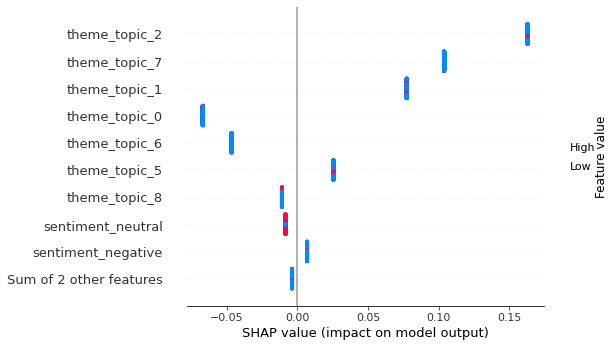

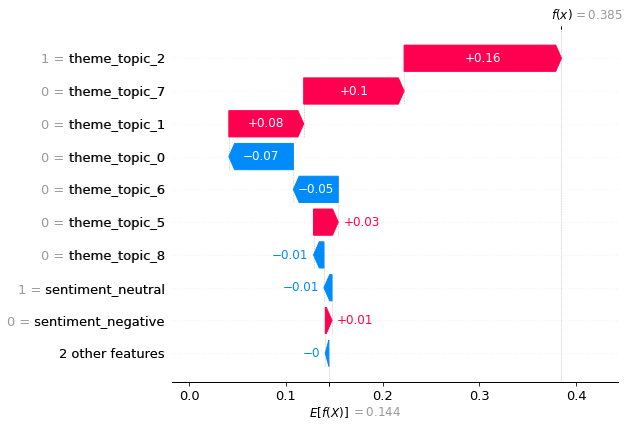

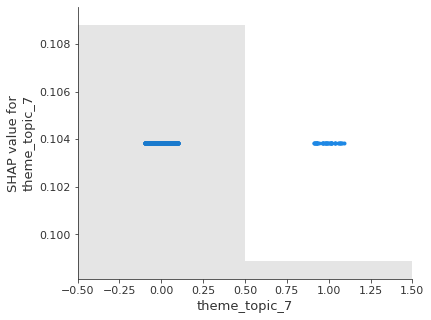

In [27]:
'''
Documentation and tutorials: 
	- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models.html
	- https://github.com/slundberg/shap 
	- https://analyticsindiamag.com/a-complete-guide-to-shap-shapley-additive-explanations-for-practitioners/
'''

explainer = shap.TreeExplainer(estimator) 
shap_values = explainer(df_features) 

# Plot. 
shap.plots.beeswarm(shap_values) 
shap.plots.waterfall(shap_values[0]) 
shap.plots.scatter(shap_values[:, 2]) 

### Save the models. 

In [28]:
# # Cache the vectorized output. 
# mlpipe_name = "mlpipe_estim" 
# dev_status, version = manage_files.resume_version(DIR_MLESTIM, dev_status=True) 
# manage_files.save_cache_pk(dir=DIR_MLESTIM, filename=f"{dev_status}/{mlpipe_name}_v{version}.pickle", object=mlpipe_estim) 
# manage_files.update_version(DIR_MLESTIM, version, dev_status=True) 
# mlpipe_topic_loaded = manage_files.load_cache_pk(dir=DIR_MLESTIM, filename=f"{dev_status}/{mlpipe_name}_v{version}.pickle") 